# 03.Linear Regression

- [Datasets](#Datasets)
- [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [3.3 Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)

## Libraries

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [83]:
from sklearn import linear_model, preprocessing
from sklearn.metrics import r2_score

import statsmodels.formula.api as smf
import statsmodels.api as sm

import empiricaldist
import scipy.stats

In [4]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

%matplotlib inline
plt.style.use('seaborn-white')

## Datasets

In [5]:
advertising = pd.read_csv('../Datasets/Advertising.csv', usecols=[1,2,3,4])
advertising.sample(5)

,TV,Radio,Newspaper,Sales
175,276.9,48.9,41.8,27.0
167,206.8,5.2,19.4,12.2
38,43.1,26.7,35.1,10.1
100,222.4,4.3,49.8,11.7
70,199.1,30.6,38.7,18.3


In [6]:
credit = pd.read_csv('../Datasets/Credit.csv', usecols=list(range(1,12)))
credit['Student2'] = credit.Student.map({'No':0, 'Yes':1})
credit.sample(5)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
6,20.996,3388,259,2,37,12,Female,No,No,African American,203,0
183,80.861,4090,335,3,29,15,Female,No,Yes,Asian,0,0
52,44.205,5441,394,1,32,12,Male,No,Yes,Caucasian,607,0
232,15.741,4788,360,1,39,14,Male,No,Yes,Asian,689,0
220,44.847,5765,437,3,53,13,Female,Yes,No,Asian,1246,1


In [7]:
auto = pd.read_csv('../Datasets/Auto.csv', na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   year          392 non-null    int64  
 7   origin        392 non-null    int64  
 8   name          392 non-null    object 
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## Simple Linear Regression

### Least squares fit

<ul>
 <li><i>Figure 3.1</i></li>
</ul>

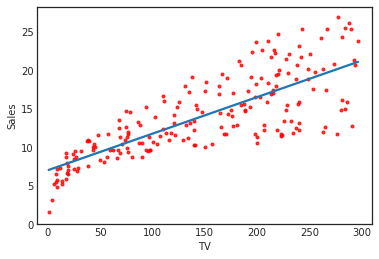

In [8]:
sns.regplot(x = advertising.TV, y = advertising.Sales, order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310)
plt.ylim(ymin=0)
plt.show()

### Regression coefficients - RSS
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

In [9]:
X = advertising[['TV']].values
y = advertising[['Sales']]

sc_x = preprocessing.StandardScaler(with_mean = True, with_std = False)
sc_y = preprocessing.StandardScaler()

X_std = sc_x.fit_transform(X)

<ul>
 <li>Regression coefficients (Ordinary Least Squares).</li>
</ul>

In [10]:
lr = linear_model.LinearRegression()

lr.fit(X_std,y)

print(f"Intercept : %0.4f" % lr.intercept_[0])
print(f"Slope : %0.4f" % lr.coef_[0][0])

Intercept : 14.0225
Slope : 0.0475


<ul>
 <li>Grid coordinates for plotting.</li>
</ul>

In [11]:
b0 = np.linspace(lr.intercept_ - 2, lr.intercept_ + 2, 50)
b1 = np.linspace(lr.coef_ - 0.02, lr.coef_ + 0.02, 50)

xx, yy = np.meshgrid(b0,b1, indexing= 'xy')
Z = np.zeros((b0.size, b1.size))

<ul>
 <li>Calculate Z-values (RSS) based on grid of coefficients.</li>
</ul>

In [12]:
for (i,j),v in np.ndenumerate(Z):
   Z[i,j] = ((y - (xx[i,j] + X_std.ravel()*yy[i,j])[:,np.newaxis])**2).sum()/1000

<ul>
 <li>Minimized RSS.</li>
</ul>

In [13]:
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((lr.intercept_ + lr.coef_ * X_std - y.values )**2)/1000
min_rss

2.1025305831313514

<ul>
 <li><i>Figure 3.2</i></li>
</ul>

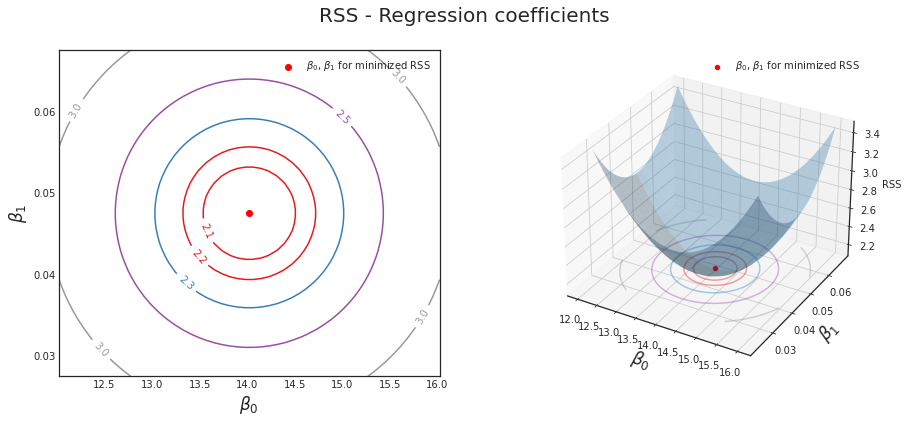

In [14]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap= plt.cm.Set1, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax1.scatter(lr.intercept_, lr.coef_[0], c= 'r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2.15, 2.2, 2.3, 2.5, 3])
ax2.scatter3D(lr.intercept_, lr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Confidence Intervals

<ul>
 <li><i>Table 3.1</i></li>
</ul>

In [85]:
model = smf.ols('Sales ~ TV', advertising).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


<ul>
 <li>Plot of Fitted Model with Confidence Intervals</li>
</ul>

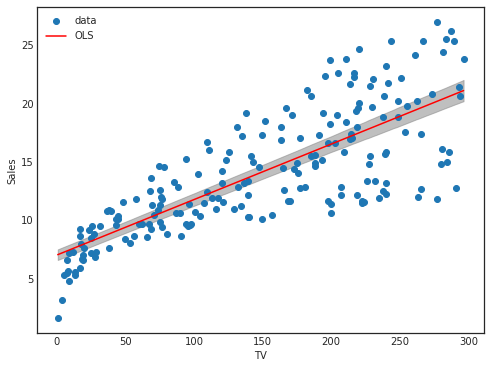

In [86]:
pred_ols = model.get_prediction()
gap = (pred_ols.summary_frame()['mean'] - pred_ols.summary_frame()['mean_ci_lower']).sort_values()

xfit = np.linspace(min(advertising.TV),max(advertising.TV),200)
yfit = model.params[0] + model.params[1]*xfit

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(advertising.TV, advertising.Sales, "o", label="data")
ax.plot(xfit, yfit, "-r", label="OLS")
ax.fill_between(xfit, 
                yfit - gap, 
                yfit + gap,
                color='gray', alpha=0.5)

ax.set_ylabel('Sales')
ax.set_xlabel('TV')
ax.legend(loc="best")
plt.show()

<ul>
 <li>Plot of Residuals Vs Fitted Model</li>
</ul>

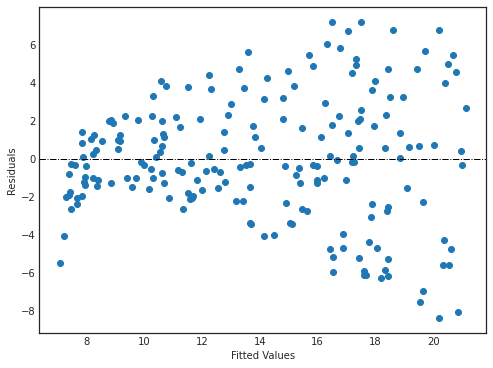

In [87]:
residuals = advertising.Sales - model.fittedvalues

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x = model.fittedvalues, y = residuals)
ax.axhline(y=0, linewidth=1, color='k', linestyle='-.')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
plt.show()

<ul>
 <li>Distribution of Residuals Vs Normal Distribution</li>
</ul>

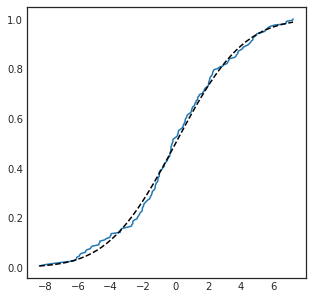

In [88]:
xs = np.linspace(residuals.min(),residuals.max())
ys = scipy.stats.norm(residuals.mean(),residuals.std()).cdf(xs)

plt.figure(figsize = (5,5))
empiricaldist.Cdf.from_seq(residuals,normalize = True).plot()
plt.plot(xs, ys, color = 'black', linestyle = 'dashed')

In [18]:
RSS = residuals.dot(residuals)
RSE = np.divide(RSS,len(residuals) - len(model.params))**(1/2)
error_mean = RSE / advertising.Sales.mean()
r2 = r2_score(advertising.Sales,pred_ols.summary_frame()['mean'])

print(f'Residual Sum of Squares (RSS): {RSS.round(2)}')
print(f'Residual Standard Error (RSE): {RSE.round(2)}')
print(f'Percentage Error: {error_mean.round(2)*100} %')
print(f'R2: {r2.round(2)}')

Residual Sum of Squares (RSS): 2102.53
Residual Standard Error (RSE): 3.26
Percentage Error: 23.0 %
R2: 0.61


## Multiple Linear Regression

<ul>
 <li>Regression coefficients (OLS).</li>
</ul>

In [74]:
X = advertising[['Radio','TV']].values
y = advertising[['Sales']]

In [75]:
lr = linear_model.LinearRegression()

lr.fit(X,y)

print(f"Intercept : %0.4f" % lr.intercept_[0])
print(f"Slope Radio : %0.4f" % lr.coef_[0][0])
print(f"Slope TV : %0.4f" % lr.coef_[0][1])

Intercept : 2.9211
Slope Radio : 0.1880
Slope TV : 0.0458


<ul>
 <li>Grid coordinates for plotting.</li>
</ul>

In [76]:
x1 = np.linspace(X[:,0].min(), X[:,0].max(), 100)
x2 = np.linspace(X[:,1].min(), X[:,1].max(), 100)

B1, B2 = np.meshgrid(x1, x2, indexing='xy')
Z = np.zeros((x1.size, x2.size))

for (i,j),v in np.ndenumerate(Z):
   Z[i,j] = (lr.intercept_ + B1[i,j]*lr.coef_[0][0] + B2[i,j]*lr.coef_[0][1])[:,np.newaxis]

<ul>
 <li>Three-dimensional settings with two predictors</li>
</ul>

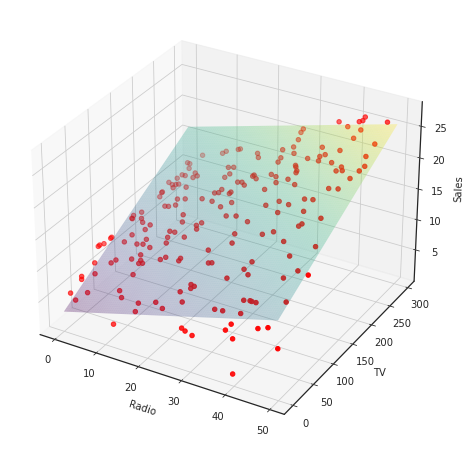

In [77]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes(projection='3d')
ax.plot_surface(B1,B2, Z, rstride=1, cstride=1,cmap='viridis', edgecolor='none', alpha = 0.3)
ax.scatter3D(xs = advertising.Radio, ys = advertising.TV, zs = advertising.Sales, c='r')

ax.set_xlabel('Radio')
ax.set_ylabel('TV')
ax.set_zlabel('Sales')

plt.show()

<ul>
 <li><i>Least Squares Coefficient</i> estimates of the
multiple linear regression of number of units sold on radio, TV, and newspaper
advertising budgets.</li>
</ul>

In [78]:
model = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
model.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.9389,0.312,9.422,0.000,2.324,3.554
TV,0.0458,0.001,32.809,0.000,0.043,0.049
Radio,0.1885,0.009,21.893,0.000,0.172,0.206
Newspaper,-0.0010,0.006,-0.177,0.860,-0.013,0.011


<ul>
 <li>Correlation Matrix</li>
</ul>

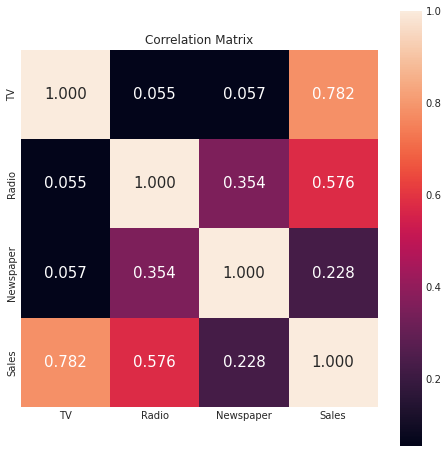

In [79]:
cm = np.corrcoef(advertising.values.T)
cols = advertising.columns

plt.figure(figsize= (8,8))
sns.heatmap(data = cm,
            cbar = True,
            annot = True,
            square = True,
            fmt = '.3f',
            annot_kws = {'size':15},
            yticklabels = cols,
            xticklabels = cols)
plt.title('Correlation Matrix')
plt.show()

<ul>
 <li>Plot of Residuals Vs Fitted Model</li>
</ul>

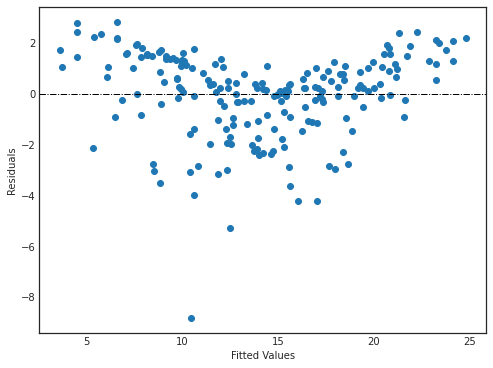

In [80]:
residuals = advertising.Sales - model.fittedvalues

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x = model.fittedvalues, y = residuals)
ax.axhline(y=0, linewidth=1, color='k', linestyle='-.')
ax.set_ylabel('Residuals')
ax.set_xlabel('Fitted Values')
plt.show()

<ul>
 <li>Distribution of Residuals Vs Normal Distribution</li>
</ul>

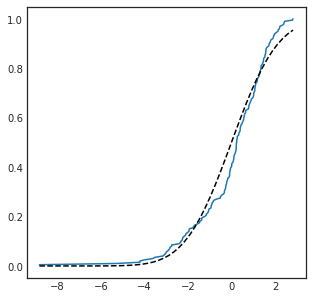

In [84]:
xs = np.linspace(residuals.min(),residuals.max())
ys = scipy.stats.norm(residuals.mean(),residuals.std()).cdf(xs)

plt.figure(figsize = (5,5))

empiricaldist.Cdf.from_seq(residuals,normalize = True).plot()
plt.plot(xs, ys, color = 'black', linestyle = 'dashed')

In [82]:
pred_ols = model.get_prediction()
RSS = residuals.dot(residuals)
RSE = np.divide(RSS,len(residuals) - len(model.params))**(1/2)
error_mean = RSE / advertising.Sales.mean()
r2 = r2_score(advertising.Sales,pred_ols.summary_frame()['mean'])

print(f'Residual Sum of Squares (RSS): {RSS.round(2)}')
print(f'Residual Standard Error (RSE): {RSE.round(2)}')
print(f'Percentage Error: {error_mean.round(2)*100} %')
print(f'R2: {r2.round(3)}')

Residual Sum of Squares (RSS): 556.83
Residual Standard Error (RSE): 1.69
Percentage Error: 12.0 %
R2: 0.897


### Figure 3.5 - Multiple Linear Regression

In [30]:
regr = linear_model.LinearRegression()


X = advertising[['Radio', 'TV']]
y = advertising[['Sales']]

regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

[[0.18799423 0.04575482]]
[2.92109991]


In [31]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['Radio', 'TV']].describe()

,Radio,TV
count,200.000000,200.000000
mean,23.264000,147.042500
std,14.846809,85.854236
min,0.000000,0.700000
25%,9.975000,74.375000
50%,22.900000,149.750000
75%,36.525000,218.825000
max,49.600000,296.400000


## 3.3 Other Considerations in the Regression Model

### Figure 3.6

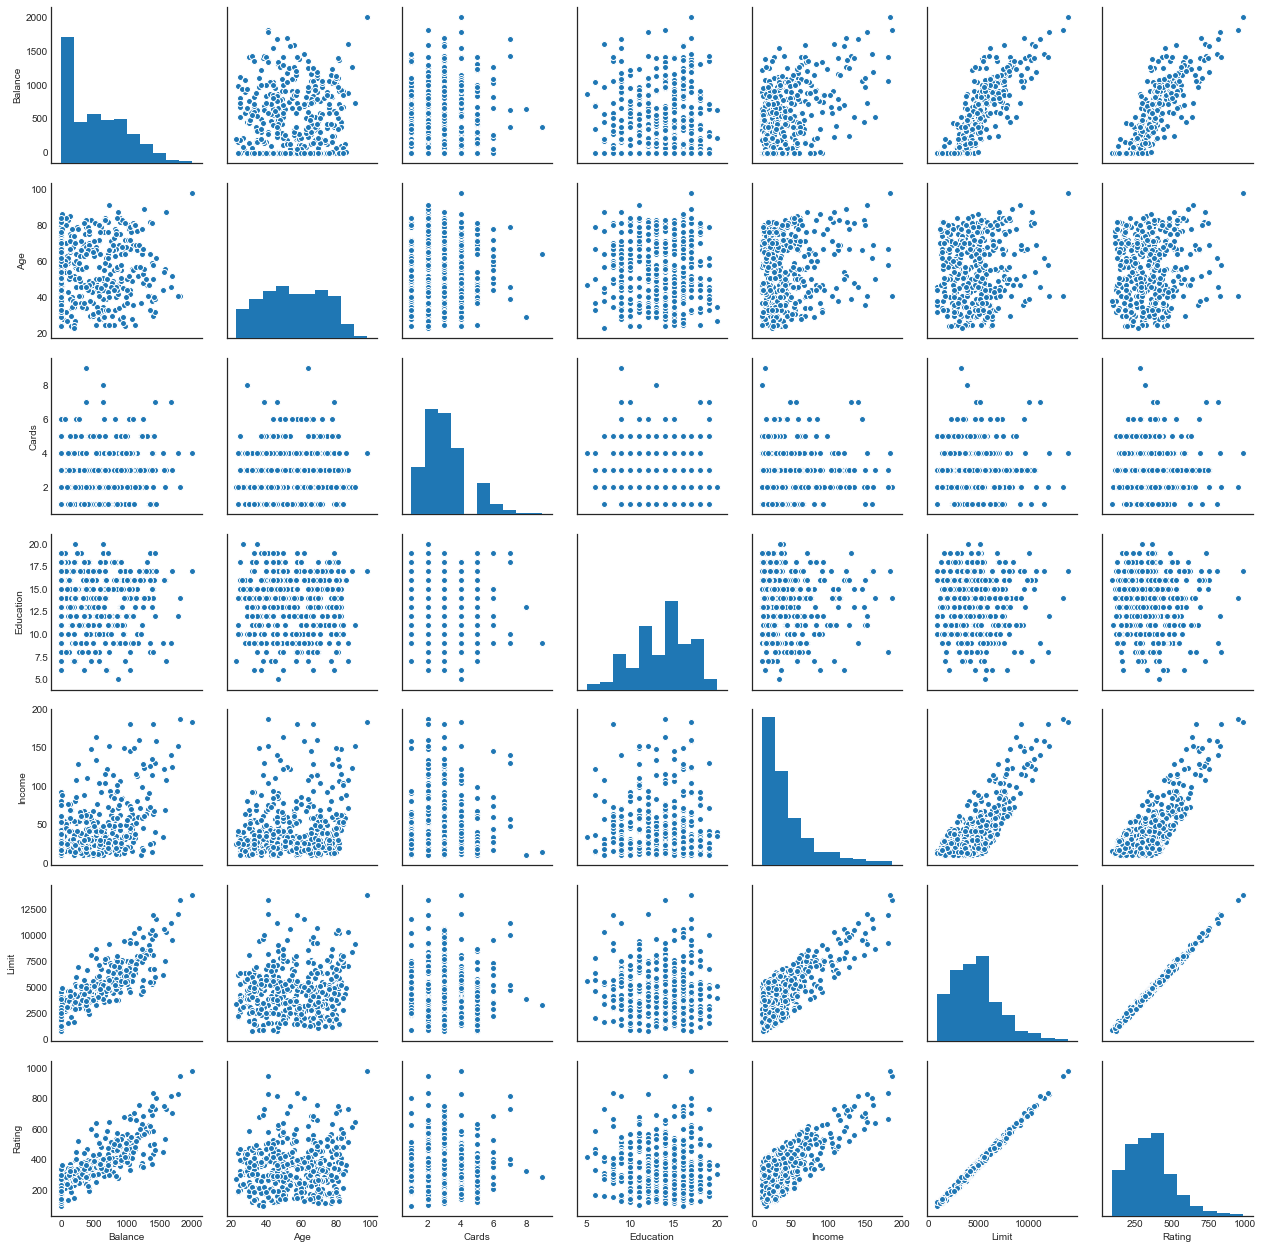

In [ ]:
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']]);

###  Table 3.7

In [ ]:
est = smf.ols('Balance ~ Gender', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,509.8031,33.128,15.389,0.000,444.675,574.931
Gender[T.Female],19.7331,46.051,0.429,0.669,-70.801,110.267


### Table 3.8

In [ ]:
est = smf.ols('Balance ~ Ethnicity', credit).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,531.0000,46.319,11.464,0.000,439.939,622.061
Ethnicity[T.Asian],-18.6863,65.021,-0.287,0.774,-146.515,109.142
Ethnicity[T.Caucasian],-12.5025,56.681,-0.221,0.826,-123.935,98.930


### Table 3.9 - Interaction Variables

In [ ]:
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


### Figure 3.7 - Interaction between qualitative and quantative variables

In [ ]:
est1 = smf.ols('Balance ~ Income + Student2', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*Student2', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
print(regr1)
print('\nRegression 2 - with interaction term')
print(regr2)

Regression 1 - without interaction term
Intercept    211.142964
Income         5.984336
Student2     382.670539
dtype: float64

Regression 2 - with interaction term
Intercept          200.623153
Income               6.218169
Student2           476.675843
Income:Student2     -1.999151
dtype: float64


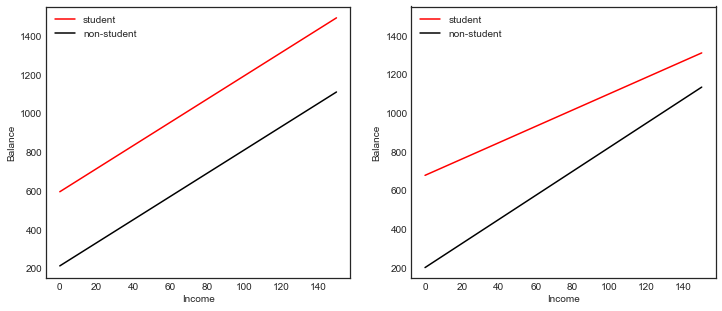

In [ ]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept']+regr1['Student2'],
                       regr1['Intercept']+regr1['Student2']+150*regr1['Income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['Student2'],
                       regr2['Intercept']+regr2['Student2']+
                       150*(regr2['Income']+regr2['Income:Student2']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['Income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

### Figure 3.8 - Non-linear relationships

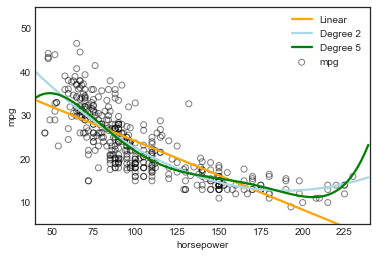

In [ ]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(auto.horsepower, auto.mpg, facecolors='None', edgecolors='k', alpha=.5) 
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

### Table 3.10

In [ ]:
auto['horsepower2'] = auto.horsepower**2
auto.head(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,horsepower2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,16900.0
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,27225.0
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,22500.0


In [ ]:
est = smf.ols('mpg ~ horsepower + horsepower2', auto).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,56.9001,1.800,31.604,0.000,53.360,60.440
horsepower,-0.4662,0.031,-14.978,0.000,-0.527,-0.405
horsepower2,0.0012,0.000,10.080,0.000,0.001,0.001


### Figure 3.9

In [ ]:
regr = skl_lm.LinearRegression()

# Linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr.fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']].as_matrix()
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

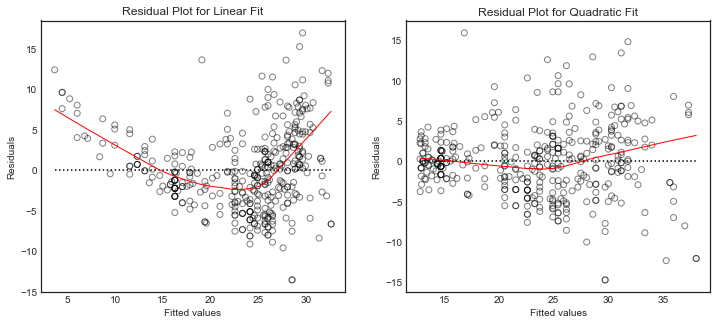

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(auto.pred1, auto.resid1, lowess=True, 
            ax=ax1, line_kws={'color':'r', 'lw':1},
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

# Right plot
sns.regplot(auto.pred2, auto.resid2, lowess=True,
            line_kws={'color':'r', 'lw':1}, ax=ax2,
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

### Figure 3.14

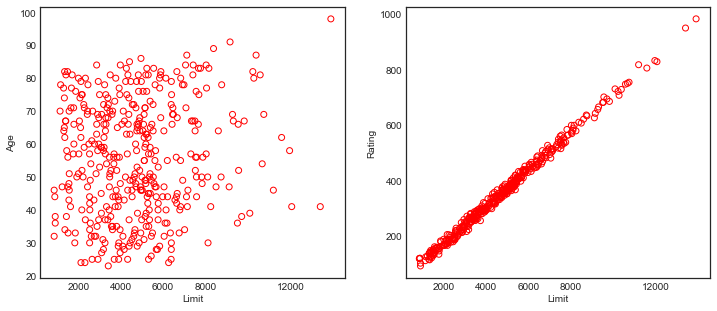

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
ax1.scatter(credit.Limit, credit.Age, facecolor='None', edgecolor='r')
ax1.set_ylabel('Age')

# Right plot
ax2.scatter(credit.Limit, credit.Rating, facecolor='None', edgecolor='r')
ax2.set_ylabel('Rating')

for ax in fig.axes:
    ax.set_xlabel('Limit')
    ax.set_xticks([2000,4000,6000,8000,12000])

### Figure 3.15

In [ ]:
y = credit.Balance

# Regression for left plot
X = credit[['Age', 'Limit']].as_matrix()
regr1 = skl_lm.LinearRegression()
regr1.fit(scale(X.astype('float'), with_std=False), y)
print('Age/Limit\n',regr1.intercept_)
print(regr1.coef_)

# Regression for right plot
X2 = credit[['Rating', 'Limit']].as_matrix()
regr2 = skl_lm.LinearRegression()
regr2.fit(scale(X2.astype('float'), with_std=False), y)
print('\nRating/Limit\n',regr2.intercept_)
print(regr2.coef_)

Age/Limit
 520.015
[-2.29148553  0.17336497]

Rating/Limit
 520.015
[ 2.20167217  0.02451438]


In [ ]:
# Create grid coordinates for plotting
B_Age = np.linspace(regr1.coef_[0]-3, regr1.coef_[0]+3, 100)
B_Limit = np.linspace(regr1.coef_[1]-0.02, regr1.coef_[1]+0.02, 100)

B_Rating = np.linspace(regr2.coef_[0]-3, regr2.coef_[0]+3, 100)
B_Limit2 = np.linspace(regr2.coef_[1]-0.2, regr2.coef_[1]+0.2, 100)

X1, Y1 = np.meshgrid(B_Limit, B_Age, indexing='xy')
X2, Y2 = np.meshgrid(B_Limit2, B_Rating, indexing='xy')
Z1 = np.zeros((B_Age.size,B_Limit.size))
Z2 = np.zeros((B_Rating.size,B_Limit2.size))

Limit_scaled = scale(credit.Limit.astype('float'), with_std=False)
Age_scaled = scale(credit.Age.astype('float'), with_std=False)
Rating_scaled = scale(credit.Rating.astype('float'), with_std=False)

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z1):
    Z1[i,j] =((y - (regr1.intercept_ + X1[i,j]*Limit_scaled +
                    Y1[i,j]*Age_scaled))**2).sum()/1000000
    
for (i,j),v in np.ndenumerate(Z2):
    Z2[i,j] =((y - (regr2.intercept_ + X2[i,j]*Limit_scaled +
                    Y2[i,j]*Rating_scaled))**2).sum()/1000000

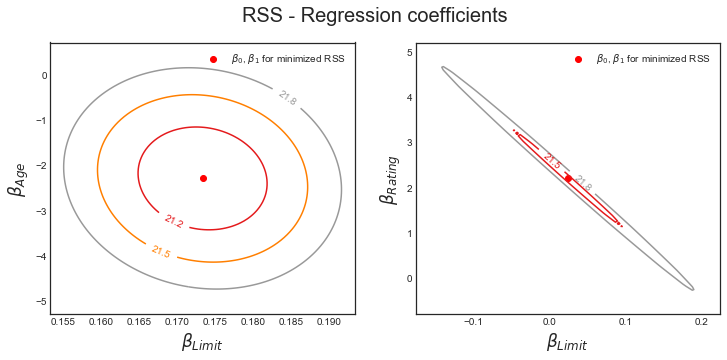

In [ ]:
fig = plt.figure(figsize=(12,5))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
    
# Left plot
CS = ax1.contour(X1, Y1, Z1, cmap=plt.cm.Set1, levels=[21.25, 21.5, 21.8])
ax1.scatter(regr1.coef_[1], regr1.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax1.set_ylabel(r'$\beta_{Age}$', fontsize=17)

# Right plot
CS = ax2.contour(X2, Y2, Z2, cmap=plt.cm.Set1, levels=[21.5, 21.8])
ax2.scatter(regr2.coef_[1], regr2.coef_[0], c='r', label=min_RSS)
ax2.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')
ax2.set_ylabel(r'$\beta_{Rating}$', fontsize=17)
ax2.set_xticks([-0.1, 0, 0.1, 0.2])

for ax in fig.axes:
    ax.set_xlabel(r'$\beta_{Limit}$', fontsize=17)
    ax.legend()

### Variance Inflation Factor - page 102

In [ ]:
est_Age = smf.ols('Age ~ Rating + Limit', credit).fit()
est_Rating = smf.ols('Rating ~ Age + Limit', credit).fit()
est_Limit = smf.ols('Limit ~ Age + Rating', credit).fit()

print(1/(1-est_Age.rsquared))
print(1/(1-est_Rating.rsquared))
print(1/(1-est_Limit.rsquared))

1.01138468607
160.668300959
160.592879786
